## Calculate standard and area-weighted global temperature average anomalies using NCEP/NCAR 

### imports 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from cartopy import crs as ccrs

In [3]:
from calendar import month_abbr

### matplotlib parameters for the figures 

In [4]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

### load the monthly NCEP (NCEP/NCAR) reanalysis temperature (2 m)

see [https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html](https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html)

In [5]:
url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc'

In [6]:
ncep_temp = xr.open_dataset(url)

In [7]:
ncep_temp = ncep_temp.sortby('lat')

In [8]:
ncep_temp

<xarray.Dataset>
Dimensions:  (lon: 144, time: 892, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-04-01
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## selects only complete years 

In [9]:
ncep_temp = ncep_temp.sel(time=slice(None, '2021'))

## levels for plotting 

In [10]:
levels=np.arange(-30, 30+5, 5)

In [11]:
levels

array([-30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30])

### calculate the time-averaged temperature for the 1950s and the 2010s

In [12]:
ncep_dec_1 =  ncep_temp.sel(time=slice('1950','1959')).mean('time')

ncep_dec_2 = ncep_temp.sel(time=slice('2010','2019')).mean('time')

### parameters for the colorbar 

In [13]:
cbar_kwargs = dict(orientation='horizontal', shrink=0.7, pad=0.05, label='\u00B0C')

### map the average temperature and the difference between the 2 decades 

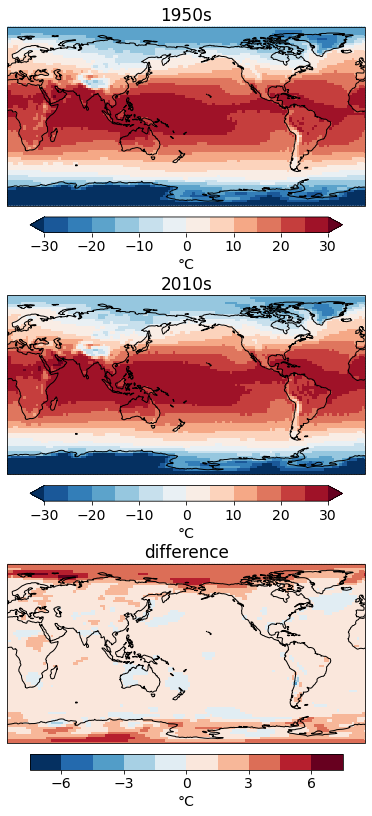

In [14]:
f, axes = plt.subplots(nrows=3, figsize=(8, 14), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ncep_dec_1['air'].plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

ncep_dec_2['air'].plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

(ncep_dec_2 - ncep_dec_1)['air'].plot(ax=axes[2], transform=ccrs.PlateCarree(), levels=10, cbar_kwargs=cbar_kwargs)

[ax.set_title(title) for ax, title in zip(axes, ['1950s','2010s','difference'])]

[ax.coastlines() for ax in axes]; 

### zoom in on the Northern Hemisphere high latitudes

In [15]:
cbar_kwargs.update(shrink=0.5)

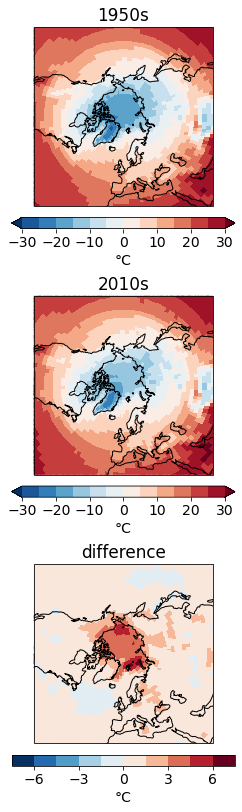

In [16]:
f, axes = plt.subplots(nrows=3, figsize=(8, 14), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

ncep_dec_1['air'].plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

ncep_dec_2['air'].plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs=cbar_kwargs)

(ncep_dec_2 - ncep_dec_1)['air'].plot(ax=axes[2], transform=ccrs.PlateCarree(), levels=10, cbar_kwargs=cbar_kwargs)

[ax.set_title(title) for ax, title in zip(axes, ['1950s','2010s','difference'])]

[ax.coastlines() for ax in axes]; 

[ax.set_extent([0, 360, 30, 90], crs=ccrs.PlateCarree()) for ax in axes];

### what does the time-series of surface temperature looks like for one location 

In [17]:
Auckland_coordinates = [174.7645, -36.8509] # longitude, latitude 

In [18]:
Auckland = ncep_temp.sel(lon=Auckland_coordinates[0], lat=Auckland_coordinates[1], method='nearest')

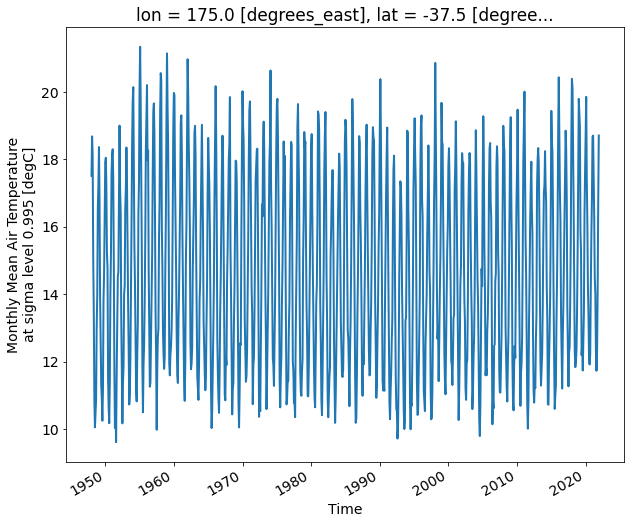

In [19]:
Auckland['air'].plot()

Text(0, 0.5, '°C')

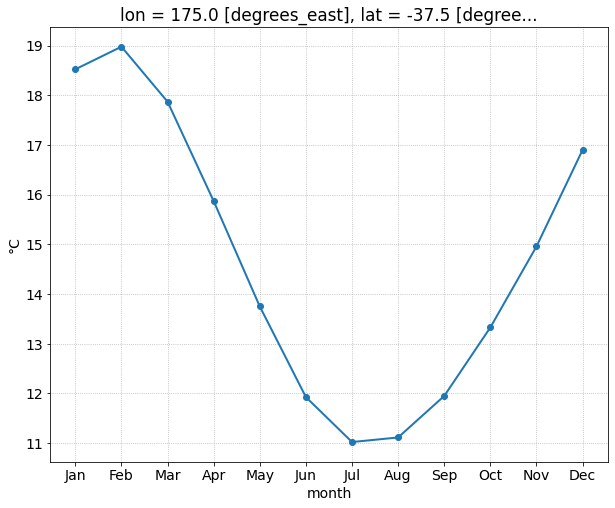

In [20]:
f, ax = plt.subplots()
Auckland.groupby(Auckland.time.dt.month).mean('time')['air'].plot(ax=ax, marker='o')
ax.set_xticks(np.arange(12) + 1)
ax.set_xticklabels(month_abbr[1:]); 
ax.grid(ls=':')
ax.set_ylabel('\u00B0C')

### we calculate, for each grid point, the *anomalies* with respect to the mean seasonal cycle (average for each month)

#### 1st step: Calculate the climatological 'normal' (now 1991 - 2010)

In [21]:
climatology = ncep_temp.sel(time=slice('1991','2010'))

In [22]:
climatology = climatology.groupby(climatology.time.dt.month).mean('time')

#### plots the climatologhy 

In [23]:
cbar_kwargs = {'shrink':0.7, 'label':'\u00B0C'}

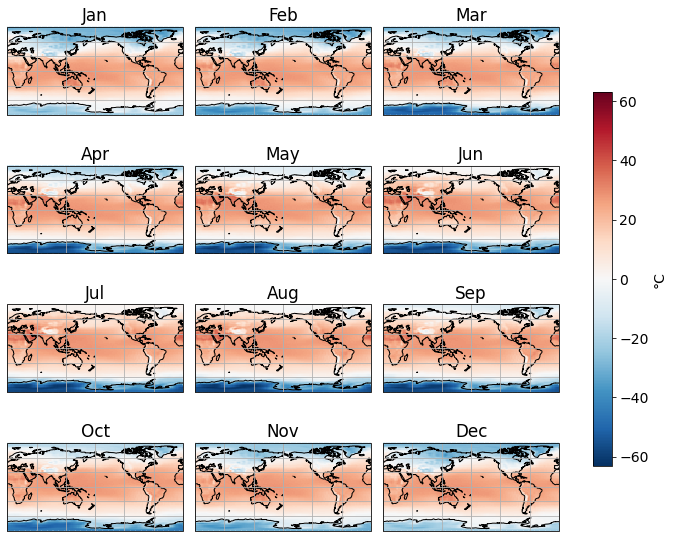

In [24]:
fg = climatology['air'].plot(figsize=(10,8), col='month', col_wrap=3, transform=ccrs.PlateCarree(), \
                            subplot_kws={"projection":ccrs.PlateCarree(central_longitude=180)}, cbar_kwargs=cbar_kwargs)

for i, ax in enumerate(fg.axes.flat):
    ax.coastlines()
    ax.gridlines()
    ax.set_title(month_abbr[i+1])

#### 2nd step: Remove this climatology from the raw data

In [25]:
ncep_temp_anomalies = ncep_temp.groupby(ncep_temp.time.dt.month) - climatology

### plots the anomalies for the December 2021 

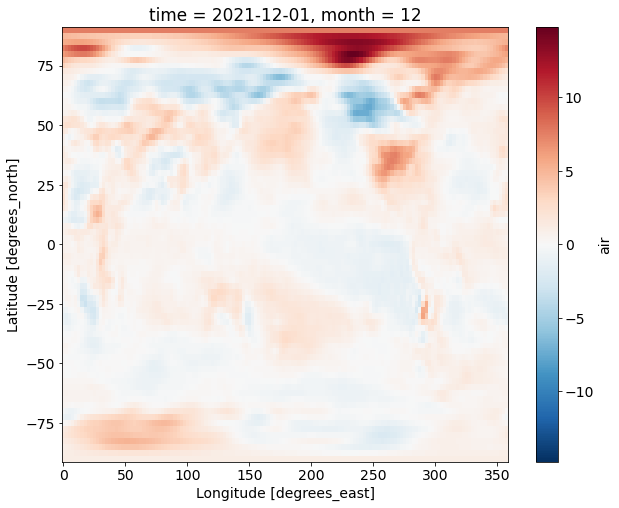

In [26]:
ncep_temp_anomalies.isel(time=-1)['air'].plot()

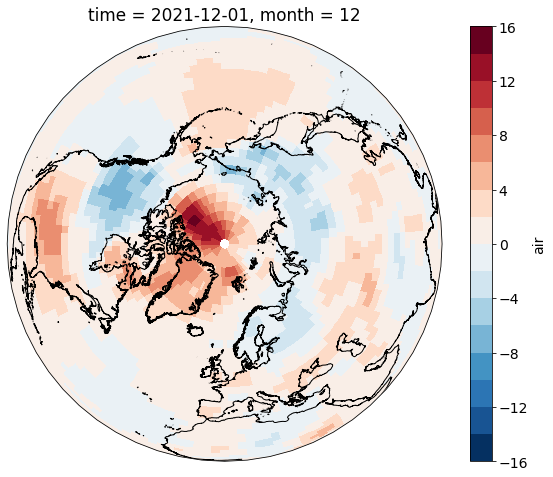

In [27]:
f, ax = plt.subplots(subplot_kw={"projection":ccrs.Orthographic(central_longitude=0, central_latitude=90)})
ncep_temp_anomalies.isel(time=-1)['air'].plot(ax=ax, levels=20, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

#### give the large difference in the area represented by grid points at low and high latitudes, we will calculate the weighted average global mean temperature anomlaies and compare the results to the standard (unweighted) anomalies 

In [28]:
latitudes = ncep_temp['lat']

In [29]:
latitudes

<xarray.DataArray 'lat' (lat: 73)>
array([-90. , -87.5, -85. , -82.5, -80. , -77.5, -75. , -72.5, -70. , -67.5,
       -65. , -62.5, -60. , -57.5, -55. , -52.5, -50. , -47.5, -45. , -42.5,
       -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5,
       -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
        10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,
        35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
        60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,
        85. ,  87.5,  90. ], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Attributes:
    units:          degrees_north
    actual_range:   [ 90. -90.]
    long_name:      Latitude
    standard_name:  latitude
    axis:           Y

In [30]:
weights = np.cos(np.deg2rad(latitudes))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 73)>
array([-4.3711388e-08,  4.3619454e-02,  8.7155797e-02,  1.3052624e-01,
        1.7364822e-01,  2.1643965e-01,  2.5881907e-01,  3.0070582e-01,
        3.4202015e-01,  3.8268346e-01,  4.2261827e-01,  4.6174860e-01,
        4.9999997e-01,  5.3729957e-01,  5.7357645e-01,  6.0876143e-01,
        6.4278758e-01,  6.7559016e-01,  7.0710677e-01,  7.3727733e-01,
        7.6604444e-01,  7.9335332e-01,  8.1915206e-01,  8.4339142e-01,
        8.6602539e-01,  8.8701081e-01,  9.0630776e-01,  9.2387950e-01,
        9.3969262e-01,  9.5371693e-01,  9.6592581e-01,  9.7629601e-01,
        9.8480773e-01,  9.9144489e-01,  9.9619472e-01,  9.9904823e-01,
        1.0000000e+00,  9.9904823e-01,  9.9619472e-01,  9.9144489e-01,
        9.8480773e-01,  9.7629601e-01,  9.6592581e-01,  9.5371693e-01,
        9.3969262e-01,  9.2387950e-01,  9.0630776e-01,  8.8701081e-01,
        8.6602539e-01,  8.4339142e-01,  8.1915206e-01,  7.9335332e-01,
        7.6604444e-01,  7.3727733e-01,  7.0710677e-01,  6.7559016e-01,
        6.4278758e-01,  6.0876143e-01,  5.7357645e-01,  5.3729957e-01,
        4.9999997e-01,  4.6174860e-01,  4.2261827e-01,  3.8268346e-01,
        3.4202015e-01,  3.0070582e-01,  2.5881907e-01,  2.1643965e-01,
        1.7364822e-01,  1.3052624e-01,  8.7155797e-02,  4.3619454e-02,
       -4.3711388e-08], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Attributes:
    units:          degrees_north
    actual_range:   [ 90. -90.]
    long_name:      Latitude
    standard_name:  latitude
    axis:           Y

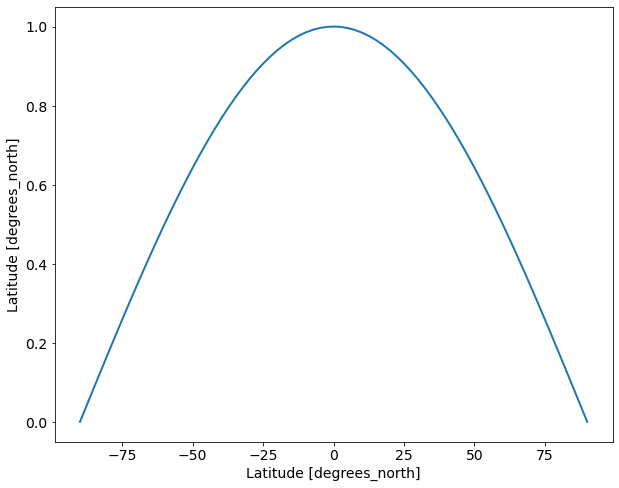

In [31]:
weights.plot()

### Standard mean

In [32]:
standard_mean = ncep_temp_anomalies['air'].mean(['lat','lon'])

In [33]:
standard_mean_smooth = standard_mean.rolling(time=12*5, center=True).mean().dropna("time")

### Weighted mean

In [34]:
weighted_mean = ncep_temp_anomalies['air'].weighted(weights)

In [35]:
weighted_mean = weighted_mean.mean(("lon", "lat"))

In [36]:
weighted_mean_smooth = weighted_mean.rolling(time=12*5, center=True).mean().dropna("time")

Text(0, 0.5, '°C anomaly')

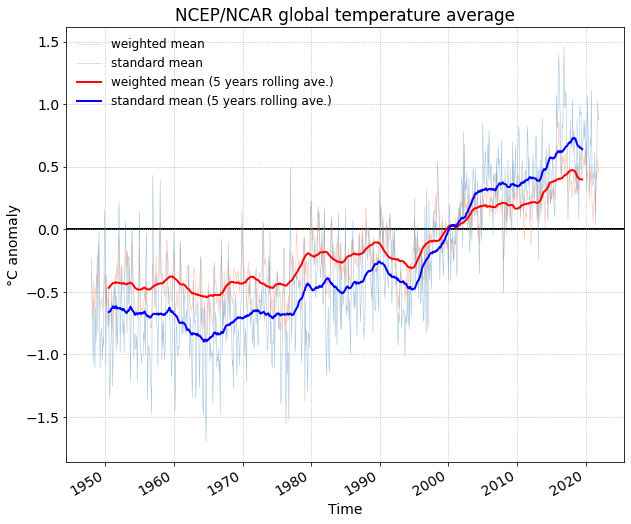

In [37]:
f, ax = plt.subplots()
weighted_mean.plot(ax=ax, label='weighted mean', color='coral', lw=0.5, alpha=0.5)
standard_mean.plot(ax=ax, label='standard mean', color='steelblue', lw=0.5, alpha=0.5)
weighted_mean_smooth.plot(ax=ax, label='weighted mean (5 years rolling ave.)', color='r')
standard_mean_smooth.plot(ax=ax, label='standard mean (5 years rolling ave.)', color='b')
ax.legend(fontsize=12, frameon=False)
ax.grid(ls=':')
ax.axhline(0, color='k', zorder=0)
ax.set_title('NCEP/NCAR global temperature average')
ax.set_ylabel('\u00B0C' + ' anomaly')

### exporting the time-series in csv 

In [38]:
standard_mean

<xarray.DataArray 'air' (time: 888)>
array([-2.31682479e-01, -6.62670851e-01, -9.23733950e-01, -1.06445420e+00,
       -5.64209521e-01, -8.71726334e-01, -1.10723019e+00, -6.29738748e-01,
       -8.90383005e-01, -4.14383888e-01, -2.02640161e-01, -8.32372725e-01,
       -1.83258057e-01, -2.82037705e-02, -6.98343337e-01, -1.10546434e+00,
       -8.99513900e-01, -7.84624040e-01, -8.47448528e-01, -1.04596281e+00,
       -8.59310687e-01, -9.38584507e-01, -2.29727671e-01,  1.61015943e-01,
       -2.34980807e-01, -1.07755113e+00, -3.66479188e-01, -6.38219297e-01,
       -7.54951000e-01, -7.80211568e-01, -5.44933438e-01, -1.13465381e+00,
       -1.35404420e+00, -1.14436483e+00, -9.30277705e-01, -5.71314991e-01,
       -9.30479944e-01, -1.25340807e+00, -8.28252077e-01, -5.37782907e-01,
       -4.45606619e-01, -6.10112727e-01, -4.66466993e-01, -9.77205575e-01,
       -5.32626748e-01, -9.22221959e-01, -8.04891229e-01, -1.02120088e-02,
        2.21558988e-01, -9.31551605e-02, -9.84972835e-01, -7.12566376e-01,
       -3.08117002e-01, -5.92953146e-01, -6.35473728e-01, -8.33813787e-01,
       -7.31409669e-01, -9.87965405e-01, -4.01437372e-01,  6.45863414e-02,
       -1.63919717e-01, -3.30791235e-01, -8.28590333e-01, -2.48727083e-01,
       -2.12643564e-01, -5.97712219e-01, -3.05513740e-01, -7.22252727e-01,
       -1.21991718e+00, -8.35296512e-01, -1.64301485e-01,  1.91025641e-02,
       -1.89194351e-01, -7.98400760e-01, -1.03039789e+00, -8.40061903e-01,
       -8.38434935e-01, -9.54687595e-01, -9.32444930e-01, -8.51384699e-01,
...
        3.47174168e-01,  1.07287705e+00,  8.32978249e-01,  8.03322256e-01,
        1.22967303e+00,  1.39791012e+00,  1.21124494e+00,  9.53022182e-01,
        8.63949478e-01,  4.04294282e-01,  4.87254232e-01,  8.38428020e-01,
        8.19185257e-01,  1.11012995e+00,  1.45879257e+00,  9.76942658e-01,
        9.84015465e-01,  1.10291195e+00,  1.05840540e+00,  6.88243449e-01,
        6.15477741e-01,  7.62649924e-02,  3.00292134e-01,  3.19719106e-01,
        4.66043264e-01,  8.76022458e-01,  6.74144745e-01,  7.34145403e-01,
        6.48771822e-01,  1.03872406e+00,  6.04224980e-01,  7.83818305e-01,
        7.78040946e-01,  5.31860888e-01,  3.69080067e-01,  5.22004724e-01,
        3.10527772e-01,  8.80905092e-01,  3.13364029e-01,  5.26297808e-01,
        8.13216120e-02,  7.17048705e-01,  9.89059746e-01,  9.19018447e-01,
        9.34975326e-01,  4.70696807e-01,  6.19441628e-01,  7.10886419e-01,
        7.20181644e-01,  8.76169264e-01,  7.25841701e-01,  8.64246964e-01,
        5.05493224e-01,  7.06035674e-01,  3.02692890e-01,  1.06366718e+00,
        8.33306491e-01,  5.89786530e-01,  5.71064591e-01,  2.99109578e-01,
        7.20872760e-01,  6.68757260e-01,  1.11544502e+00,  5.12943923e-01,
        3.68009001e-01,  3.43402952e-01,  4.50712591e-01,  4.08693045e-01,
        6.14191353e-01,  3.39287184e-02,  4.57648396e-01,  3.93759251e-01,
        8.07949483e-01,  1.02281988e+00,  8.72977376e-01,  8.92118752e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [39]:
weighted_mean

<xarray.DataArray 'air' (time: 888)>
array([-0.34442008, -0.5339071 , -0.7069983 , -0.6188456 , -0.40712819,
       -0.4947633 , -0.6620312 , -0.47432652, -0.5120126 , -0.366232  ,
       -0.35711777, -0.46248043, -0.12630327, -0.3066827 , -0.53147393,
       -0.6420591 , -0.5809101 , -0.57755274, -0.5412624 , -0.64407635,
       -0.59405464, -0.543419  , -0.43443432, -0.35580507, -0.42857847,
       -0.586083  , -0.46705148, -0.6156104 , -0.5748827 , -0.5636145 ,
       -0.44785303, -0.75102705, -0.6818897 , -0.67620564, -0.7011829 ,
       -0.46573642, -0.59499836, -0.8153091 , -0.61896044, -0.53741187,
       -0.40088078, -0.3999949 , -0.360262  , -0.4512294 , -0.2624174 ,
       -0.38880944, -0.31515452, -0.05787133, -0.0856273 , -0.1520771 ,
       -0.41844025, -0.4335123 , -0.29388818, -0.2853436 , -0.4037736 ,
       -0.5057301 , -0.42340592, -0.41445547, -0.39519042, -0.21597897,
       -0.21757975, -0.17413315, -0.30785385, -0.1651491 , -0.24174951,
       -0.23950164, -0.22319937, -0.41639978, -0.49603862, -0.37600005,
       -0.27553442, -0.0996381 , -0.3192779 , -0.4267403 , -0.52329606,
       -0.5886175 , -0.6070141 , -0.66966116, -0.6598929 , -0.6441982 ,
       -0.70353115, -0.60402215, -0.45194885, -0.43991965, -0.16132408,
       -0.5773687 , -0.698056  , -0.6999921 , -0.62534493, -0.6583688 ,
       -0.63418216, -0.5922251 , -0.5528601 , -0.47523013, -0.6066408 ,
       -0.5081712 , -0.41803458, -0.6809495 , -0.700132  , -0.71730447,
...
        0.30135787,  0.2014133 ,  0.22248216,  0.00836685,  0.25727347,
        0.30013427,  0.3838392 ,  0.1984311 ,  0.22209403,  0.3161056 ,
        0.35590717,  0.38610432,  0.21024466,  0.27030224,  0.23399489,
        0.28889707,  0.33220285,  0.23862088,  0.3448699 ,  0.27334866,
        0.24071522,  0.39612615,  0.48525077,  0.6715977 ,  0.6173044 ,
        0.6796142 ,  0.68755436,  0.86358494,  0.8280978 ,  0.70577586,
        0.54042524,  0.43819103,  0.49017555,  0.51736784,  0.59084475,
        0.5240924 ,  0.5831562 ,  0.44980848,  0.5100209 ,  0.59492373,
        0.6117378 ,  0.41004378,  0.4697995 ,  0.31068942,  0.37530595,
        0.42720282,  0.4328925 ,  0.4770204 ,  0.35668695,  0.38631362,
        0.25536072,  0.30304357,  0.37625557,  0.44795114,  0.3560007 ,
        0.27761483,  0.3379993 ,  0.28418666,  0.31243667,  0.4025921 ,
        0.27987817,  0.3445712 ,  0.32053557,  0.4113618 ,  0.6273678 ,
        0.56608534,  0.47852373,  0.4226398 ,  0.44829264,  0.47849798,
        0.53512746,  0.5800863 ,  0.5116029 ,  0.6321507 ,  0.57680124,
        0.5790782 ,  0.40191412,  0.47155058,  0.40650132,  0.2918994 ,
        0.2899811 ,  0.23744139,  0.46586838,  0.38294616,  0.51812375,
        0.21104874,  0.18023165,  0.05444477,  0.19745888,  0.23899348,
        0.32662344,  0.11744967,  0.2912203 ,  0.31872305,  0.50763685,
        0.56147796,  0.48613882,  0.45220163], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [40]:
weighted_mean.name = 'weighted mean'

In [41]:
standard_mean.name = 'standard mean'

In [42]:
global_means = xr.merge([weighted_mean, standard_mean])

In [43]:
global_means = global_means.to_pandas()

In [44]:
global_means.head()

,month,weighted mean,standard mean
time,,,
1948-01-01,1,-0.344420,-0.231682
1948-02-01,2,-0.533907,-0.662671
1948-03-01,3,-0.706998,-0.923734
1948-04-01,4,-0.618846,-1.064454
1948-05-01,5,-0.407128,-0.564210


In [45]:
global_means = global_means.drop('month', axis=1)

In [46]:
global_means.head()

,weighted mean,standard mean
time,,
1948-01-01,-0.344420,-0.231682
1948-02-01,-0.533907,-0.662671
1948-03-01,-0.706998,-0.923734
1948-04-01,-0.618846,-1.064454
1948-05-01,-0.407128,-0.564210


<AxesSubplot:xlabel='time'>

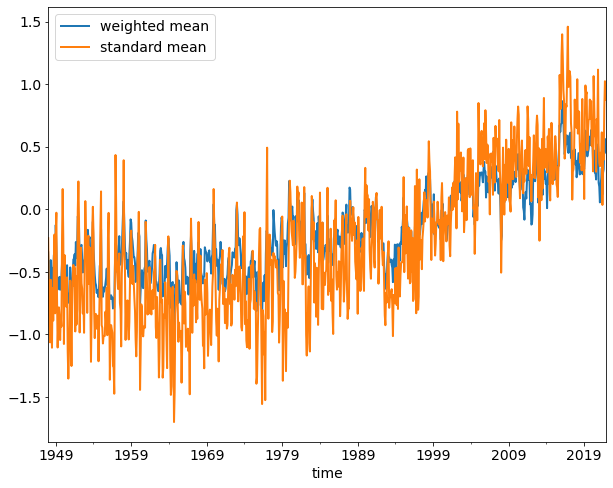

In [47]:
global_means.plot()

In [48]:
global_means_smooth = global_means.rolling(window=12*5, min_periods=12*5, center=True).mean()

In [49]:
global_means_smooth.columns = ['weighted mean (5 years rolling ave.)', \
                               'standard mean (5 years rolling ave.)']

<AxesSubplot:xlabel='time'>

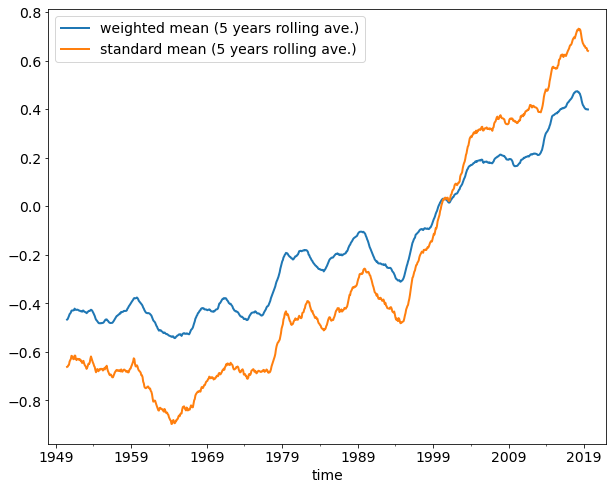

In [50]:
global_means_smooth.plot()

In [51]:
all_means = pd.concat([global_means, global_means_smooth], axis=1)

In [52]:
all_means

,weighted mean,standard mean,weighted mean (5 years rolling ave.),standard mean (5 years rolling ave.)
time,,,,
1948-01-01,-0.344420,-0.231682,NaN,NaN
1948-02-01,-0.533907,-0.662671,NaN,NaN
1948-03-01,-0.706998,-0.923734,NaN,NaN
1948-04-01,-0.618846,-1.064454,NaN,NaN
1948-05-01,-0.407128,-0.564210,NaN,NaN
...,...,...,...,...
2021-08-01,0.318723,0.393759,NaN,NaN
2021-09-01,0.507637,0.807949,NaN,NaN
2021-10-01,0.561478,1.022820,NaN,NaN


In [53]:
all_means.to_csv('../data/NCEP_global_means.csv')

In [54]:
data = pd.read_csv('../data/NCEP_global_means.csv', index_col=0, parse_dates=True)

In [55]:
data.head()

,weighted mean,standard mean,weighted mean (5 years rolling ave.),standard mean (5 years rolling ave.)
time,,,,
1948-01-01,-0.344420,-0.231682,NaN,NaN
1948-02-01,-0.533907,-0.662671,NaN,NaN
1948-03-01,-0.706998,-0.923734,NaN,NaN
1948-04-01,-0.618846,-1.064454,NaN,NaN
1948-05-01,-0.407128,-0.564210,NaN,NaN


<AxesSubplot:xlabel='time'>

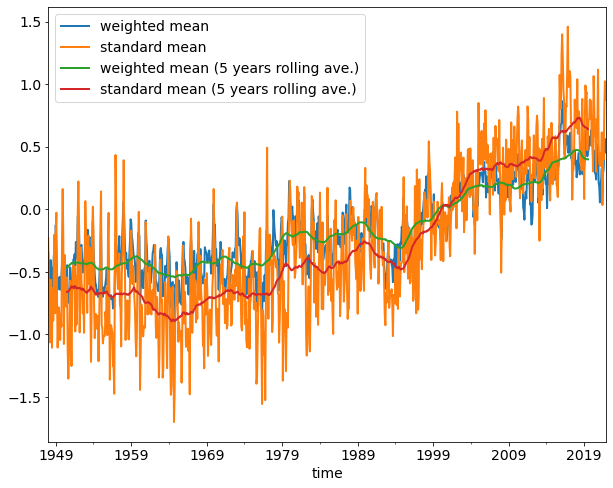

In [56]:
data.plot()